<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/ICP_ORB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Истинные:  dx=10, dy=0, angle=15°
Найденные: dx=-9.66, dy=2.60, angle=-15.0°


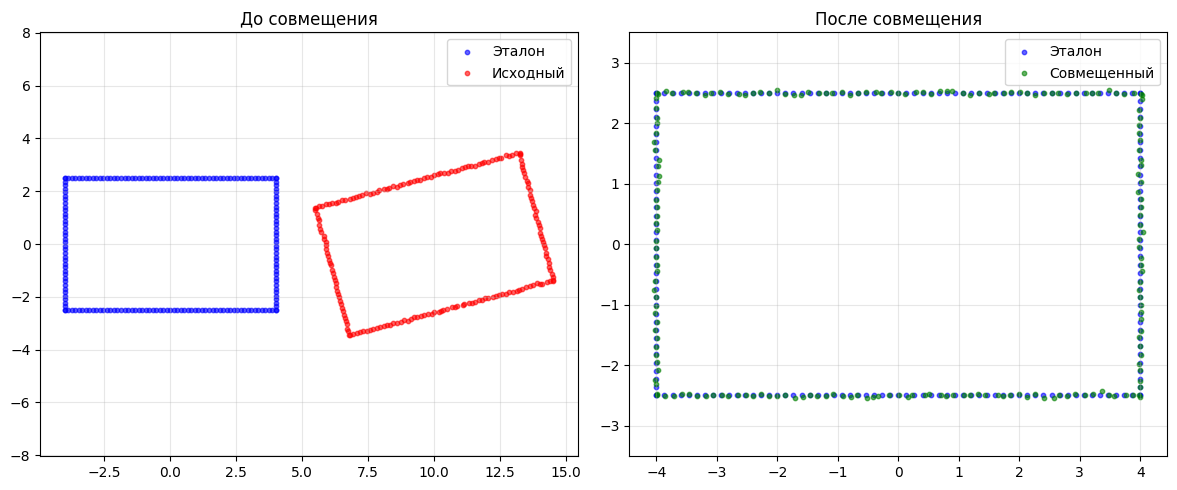

Среднее расстояние между точками: 0.0236


In [60]:
import numpy as np
import matplotlib.pyplot as plt

def create_rectangle_perimeter(center, width, height, num_points):
    """Создает точки только по периметру прямоугольника"""
    w, h = width/2, height/2
    cx, cy = center

    # Распределяем точки по периметру
    perimeter = 2 * (width + height)
    points_per_side = np.maximum(1, (num_points * np.array([width, height, width, height]) / perimeter)).astype(int)

    points = []
    # Верхняя сторона
    points.append(np.column_stack([
        np.linspace(cx - w, cx + w, points_per_side[0]),
        np.full(points_per_side[0], cy + h)
    ]))
    # Правая сторона
    points.append(np.column_stack([
        np.full(points_per_side[1], cx + w),
        np.linspace(cy + h, cy - h, points_per_side[1])
    ]))
    # Нижняя сторона
    points.append(np.column_stack([
        np.linspace(cx + w, cx - w, points_per_side[2]),
        np.full(points_per_side[2], cy - h)
    ]))
    # Левая сторона
    points.append(np.column_stack([
        np.full(points_per_side[3], cx - w),
        np.linspace(cy - h, cy + h, points_per_side[3])
    ]))

    return np.vstack(points)

def align_rectangles(src, dst):
    """Совмещает два прямоугольника"""
    # Центрируем
    src_center = np.mean(src, axis=0)
    dst_center = np.mean(dst, axis=0)

    src_centered = src - src_center
    dst_centered = dst - dst_center

    # Находим поворот
    H = src_centered.T @ dst_centered
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Угол и смещение
    angle = np.degrees(np.arctan2(R[1, 0], R[0, 0]))
    translation = dst_center - src_center @ R.T

    # Применяем
    aligned = src @ R.T + translation

    return aligned, translation, angle

# Тестовые данные
np.random.seed(42)

# Эталонный прямоугольник
ref = create_rectangle_perimeter((0, 0), 8, 5, 200)

# Второй прямоугольник - повернутый и смещенный
true_angle, true_dx, true_dy = 15, 10, 0
angle_rad = np.radians(true_angle)
R_true = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                   [np.sin(angle_rad), np.cos(angle_rad)]])
src = ref @ R_true.T + [true_dx, true_dy]
src += np.random.normal(0, 0.02, src.shape)  # шум

# Совмещаем
aligned, translation, angle = align_rectangles(src, ref)

print(f"Истинные:  dx={true_dx}, dy={true_dy}, angle={true_angle}°")
print(f"Найденные: dx={translation[0]:.2f}, dy={translation[1]:.2f}, angle={angle:.1f}°")

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(ref[:,0], ref[:,1], c='blue', s=10, alpha=0.6, label='Эталон')
ax1.scatter(src[:,0], src[:,1], c='red', s=10, alpha=0.6, label='Исходный')
ax1.set_title('До совмещения')
ax1.axis('equal')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.scatter(ref[:,0], ref[:,1], c='blue', s=10, alpha=0.6, label='Эталон')
ax2.scatter(aligned[:,0], aligned[:,1], c='green', s=10, alpha=0.6, label='Совмещенный')
ax2.set_title('После совмещения')
ax2.axis('equal')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Проверка точности
dist = np.mean(np.sqrt(np.sum((aligned - ref)**2, axis=1)))
print(f"Среднее расстояние между точками: {dist:.4f}")

Смещение по X: 0.04 пикселей
Смещение по Y: 206.90 пикселей
Поворот: -15.00 градусов


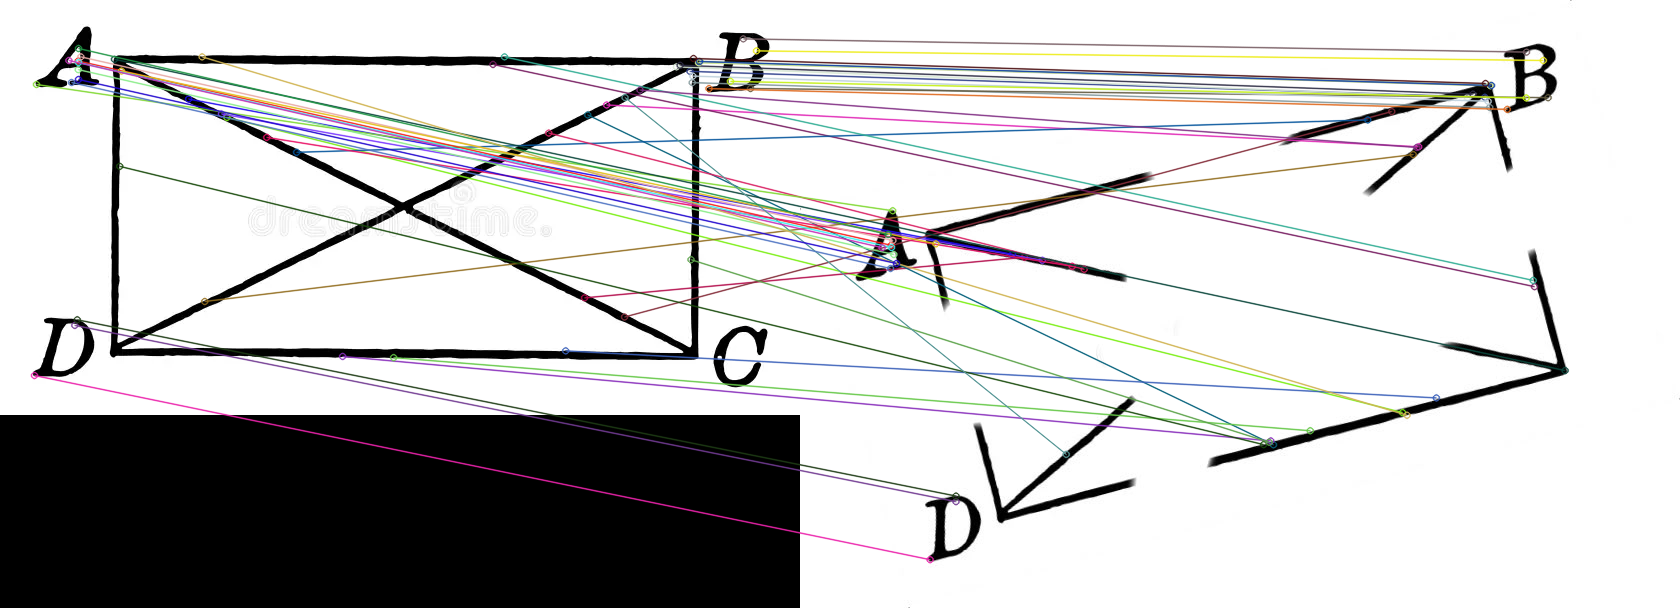

In [56]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def calculate_motion(prev_frame, curr_frame):
    """
    Вычисляет смещение и поворот между двумя кадрами
    """
    # Создаем детектор ORB
    orb = cv2.ORB_create(nfeatures=1000)

    # Находим ключевые точки и дескрипторы
    kp1, des1 = orb.detectAndCompute(prev_frame, None)
    kp2, des2 = orb.detectAndCompute(curr_frame, None)

    # Создаем matcher для сопоставления дескрипторов
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Сопоставляем дескрипторы
    matches = bf.match(des1, des2)

    # Сортируем по расстоянию
    matches = sorted(matches, key=lambda x: x.distance)

    # Берем только хорошие совпадения (первые 30%)
    good_matches = matches[:int(len(matches) * 0.3)]

    # Если недостаточно совпадений, возвращаем None
    if len(good_matches) < 4:
        return None, None, None

    # Извлекаем координаты совпадающих точек
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Находим аффинное преобразование
    transform_matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts)

    if transform_matrix is None:
        return None, None, None

    # Извлекаем смещение и поворот из матрицы преобразования
    dx = transform_matrix[0, 2]
    dy = transform_matrix[1, 2]

    # Вычисляем угол поворота (в градусах)
    angle = np.arctan2(transform_matrix[1, 0], transform_matrix[0, 0]) * 180 / np.pi

    return dx, dy, angle, good_matches, kp1, kp2

def draw_matches(prev_frame, curr_frame, kp1, kp2, matches):
    """
    Визуализирует совпадения ключевых точек
    """
    return cv2.drawMatches(prev_frame, kp1, curr_frame, kp2,
                          matches[:50], None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Основной код
def main():
    # Загружаем два изображения
    img1 = cv2.imread('frame1.jpg', cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread('frame2.jpg', cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        print("Ошибка: не удалось загрузить изображения")
        return

    # Вычисляем смещение и поворот
    result = calculate_motion(img1, img2)

    if result[0] is not None:
        dx, dy, angle, good_matches, kp1, kp2 = result

        print(f"Смещение по X: {dx:.2f} пикселей")
        print(f"Смещение по Y: {dy:.2f} пикселей")
        print(f"Поворот: {angle:.2f} градусов")

        # Визуализируем совпадения
        img_matches = draw_matches(img1, img2, kp1, kp2, good_matches)
        cv2_imshow(img_matches)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("Недостаточно совпадений для вычисления преобразования")

if __name__ == "__main__":
    main()